In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score
print(tf.__version__)

2.3.0


In [2]:
import tensorflow as tf
from keras.utils import np_utils

fashion_mnist = tf.keras.datasets.fashion_mnist

# load the training and test data    
(tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()

# reshape the feature data
tr_x = tr_x.reshape(tr_x.shape[0], 784)
te_x = te_x.reshape(te_x.shape[0], 784)

# noramlise feature data
tr_x = tr_x / 255.0
te_x = te_x / 255.0

print( "Shape of training features ", tr_x.shape)
print( "Shape of test features ", te_x.shape)


# one hot encode the training labels and get the transpose
tr_y = np_utils.to_categorical(tr_y,10)
tr_y = tr_y.T
print ("Shape of training labels ", tr_y.shape)

# one hot encode the test labels and get the transpose
te_y = np_utils.to_categorical(te_y,10)
te_y = te_y.T
print ("Shape of testing labels ", te_y.shape)

Shape of training features  (60000, 784)
Shape of test features  (10000, 784)
Shape of training labels  (10, 60000)
Shape of testing labels  (10, 10000)


In [3]:
# Converting the numpy arrays to tensors
tr_x = tf.convert_to_tensor(tr_x, dtype=tf.float64)
tr_y = tf.convert_to_tensor(tr_y, dtype=tf.float64)
te_x = tf.convert_to_tensor(te_x, dtype=tf.float64)
te_y = tf.convert_to_tensor(te_y, dtype=tf.float64)

In [4]:
# Implementation of softmax
def softmax(previous_activations):
    t = tf.cast(tf.exp(previous_activations), tf.float64) # Numerator part of the softmax (exp(x))
    pred_probabilities = tf.cast(t / tf.reduce_sum(t, axis = 0), tf.float64) # Summing along the rows (each column represents one data point)
    return pred_probabilities

In [22]:
def forward_pass(data, W1, b1, W2, b2, W3, b3):
    # set dropout probability
    dropout_prob = 0.5
    prob_threshold = 1 - dropout_prob

    # Create the dropout matrix which will be of type boolean, then convert it to numerical
    dropout_matrix_hidden_layer1 = tf.random.uniform(shape=[W1.shape[0], data.shape[0]]) < prob_threshold
    dropout_matrix_hidden_layer1 = tf.cast(dropout_matrix_hidden_layer1, dtype = tf.float64)

    # Calculating activations of Layer1
    hypothesis_hidden_layer1 = tf.cast(tf.matmul(W1, tf.transpose(data)) + b1, tf.float64)
    activations_hidden_layer1 = tf.cast(tf.nn.relu(hypothesis_hidden_layer1), tf.float64)

    # Applying the dropout functionality at Layer1 before feeding it to the next layer
    activations_hidden_layer1 = tf.multiply(activations_hidden_layer1, dropout_matrix_hidden_layer1)
    activations_hidden_layer1 /= prob_threshold

    # Calculating activations of Layer2
    hypothesis_hidden_layer2 = tf.cast(tf.matmul(W2, activations_hidden_layer1) + b2, tf.float64)
    activations_hidden_layer2 = tf.cast(tf.nn.relu(hypothesis_hidden_layer2), tf.float64)

    # Calculating class probabilities
    hypothesis_output_layer = tf.cast(tf.matmul(W3, activations_hidden_layer2) + b3, tf.float64)
    class_probabilities = tf.cast(softmax(hypothesis_output_layer), tf.float64)
    
    # returning the predictions
    return class_probabilities

In [6]:
def cross_entropy(_predictions, _true_labels):
    # Computing negative log likelihood, adding a small number within the log function to avoid log(0)
    loss = tf.cast(tf.reduce_mean(-tf.reduce_sum(_true_labels * tf.math.log(_predictions+1e-7), axis=0)), tf.float64)
    return loss

In [7]:
def calculate_accuracy(true_labels, predictions):
    predictions = tf.round(predictions) # Rounding off the decimal representation of softmax output to nearest integer(>0.5 to 1 and <0.5 to 0)
    
    # argmax to get the index of the predicted array, axis = 0 to get the index for each data point prediction
    accuracy = tf.cast(accuracy_score(np.argmax(predictions, axis = 0), np.argmax(true_labels, axis = 0)), tf.float64)
    return accuracy

In [23]:
# lists to store the loss and accuracy for train and test data
tr_loss = []
te_loss = []
tr_accuracy = []
te_accuracy = []

# Function to iterate and update the weigths and bias values using adam optimizer
def train(tr_x, W1, b1, W2, b2, W3, b3, tr_y, te_x, te_y):
    max_iterations = 1000
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    for i in range(max_iterations):
        # Record the computation
        with tf.GradientTape() as tape:
            predictions = forward_pass(tr_x, W1, b1, W2, b2, W3, b3)
            train_loss = cross_entropy(predictions, tr_y)

        # Calculate the gradients
        gradients = tape.gradient(train_loss, [W1, b1, W2, b2, W3, b3])
        train_accuracy = calculate_accuracy(tr_y, predictions)

        test_predictions = forward_pass(te_x, W1, b1, W2, b2, W3, b3)
        test_loss = cross_entropy(test_predictions, te_y)
        test_accuracy = calculate_accuracy(te_y, test_predictions)
        
        tr_loss.append(train_loss)
        te_loss.append(test_loss)

        tr_accuracy.append(train_accuracy)
        te_accuracy.append(test_accuracy)

        # update the weights and bias values as per calculated gradients
        adam_optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2, W3, b3]))
        
        print("Iteraions {}: train_loss: {} train_accuracy: {} test_loss: {} test_accuracy: {}".format(i, train_loss, train_accuracy, test_loss, test_accuracy))

In [24]:
# Defining the model
no_of_features = tr_x.shape[1]
no_of_neurons_hidden_layer1 = 300
no_of_neurons_hidden_layer2 = 100
no_of_output_units = 10

# Declaring weights and bias for the NN
W1 = tf.Variable(tf.random.normal(shape=(no_of_neurons_hidden_layer1, no_of_features), seed=0, dtype=tf.float64) * 0.01)
b1 = tf.Variable([0], dtype=tf.float64)

W2 = tf.Variable(tf.random.normal(shape=(no_of_neurons_hidden_layer2, no_of_neurons_hidden_layer1), seed=0, dtype=tf.float64) * 0.01)
b2 = tf.Variable([0], dtype=tf.float64)

W3 = tf.Variable(tf.random.normal(shape=(no_of_output_units, no_of_neurons_hidden_layer2), seed=0, dtype=tf.float64) * 0.01)
b3 = tf.Variable([0], dtype=tf.float64)

## Below is for dropout prob = 0.2

In [18]:
# Call train function and run it for specified number of iterations (max_iterations = 1000)
train(tr_x, W1, b1, W2, b2, W3, b3, tr_y, te_x, te_y)

Iteraions 0: train_loss: 2.302551451564751 train_accuracy: 0.1 test_loss: 2.302541590541721 test_accuracy: 0.1
Iteraions 1: train_loss: 2.2990545073228663 train_accuracy: 0.1 test_loss: 2.29908482879066 test_accuracy: 0.1
Iteraions 2: train_loss: 2.292396926305358 train_accuracy: 0.1 test_loss: 2.2924556218323686 test_accuracy: 0.1
Iteraions 3: train_loss: 2.2810110670234534 train_accuracy: 0.1 test_loss: 2.281063747330615 test_accuracy: 0.1
Iteraions 4: train_loss: 2.263184059001613 train_accuracy: 0.1 test_loss: 2.263398027280038 test_accuracy: 0.1
Iteraions 5: train_loss: 2.237303216806063 train_accuracy: 0.1 test_loss: 2.237598989128144 test_accuracy: 0.1
Iteraions 6: train_loss: 2.2021116597679375 train_accuracy: 0.1 test_loss: 2.2024020678809966 test_accuracy: 0.1
Iteraions 7: train_loss: 2.1564709286934276 train_accuracy: 0.1 test_loss: 2.156704352626812 test_accuracy: 0.1
Iteraions 8: train_loss: 2.100293502718194 train_accuracy: 0.1 test_loss: 2.101102065848616 test_accuracy: 

Iteraions 66: train_loss: 0.6558600874548676 train_accuracy: 0.6871 test_loss: 0.6792502617604212 test_accuracy: 0.6801
Iteraions 67: train_loss: 0.6500926761888415 train_accuracy: 0.6897833333333333 test_loss: 0.6729276644208894 test_accuracy: 0.6843
Iteraions 68: train_loss: 0.6468535104891772 train_accuracy: 0.6951166666666667 test_loss: 0.6722288137823184 test_accuracy: 0.6838
Iteraions 69: train_loss: 0.6406425033800801 train_accuracy: 0.6989333333333333 test_loss: 0.6662719457857974 test_accuracy: 0.6864
Iteraions 70: train_loss: 0.6354884409479263 train_accuracy: 0.7000666666666666 test_loss: 0.6618527027443 test_accuracy: 0.6927
Iteraions 71: train_loss: 0.6303463405268243 train_accuracy: 0.7028333333333333 test_loss: 0.6583793367955746 test_accuracy: 0.6933
Iteraions 72: train_loss: 0.625745169796736 train_accuracy: 0.7077166666666667 test_loss: 0.6558657149319447 test_accuracy: 0.697
Iteraions 73: train_loss: 0.6229928337732925 train_accuracy: 0.7103833333333334 test_loss: 0.

Iteraions 130: train_loss: 0.45455692826621963 train_accuracy: 0.809 test_loss: 0.4937306706038633 test_accuracy: 0.7911
Iteraions 131: train_loss: 0.4539641579691795 train_accuracy: 0.8103666666666667 test_loss: 0.48991536257234863 test_accuracy: 0.7987
Iteraions 132: train_loss: 0.45144574252805786 train_accuracy: 0.8111333333333334 test_loss: 0.48787453121253577 test_accuracy: 0.7944
Iteraions 133: train_loss: 0.45017403922142296 train_accuracy: 0.8123166666666667 test_loss: 0.482353182429588 test_accuracy: 0.802
Iteraions 134: train_loss: 0.44821537922613847 train_accuracy: 0.81265 test_loss: 0.4805750002557403 test_accuracy: 0.8009
Iteraions 135: train_loss: 0.4467017066546307 train_accuracy: 0.8143833333333333 test_loss: 0.48047566098091954 test_accuracy: 0.801
Iteraions 136: train_loss: 0.4443528327058254 train_accuracy: 0.8150166666666666 test_loss: 0.4812959221703488 test_accuracy: 0.8018
Iteraions 137: train_loss: 0.44261326183493166 train_accuracy: 0.81535 test_loss: 0.48026

Iteraions 194: train_loss: 0.36954489130459334 train_accuracy: 0.849 test_loss: 0.4124426260131098 test_accuracy: 0.8299
Iteraions 195: train_loss: 0.36894161035768663 train_accuracy: 0.84845 test_loss: 0.4080675942766284 test_accuracy: 0.831
Iteraions 196: train_loss: 0.3675955369720903 train_accuracy: 0.8496333333333334 test_loss: 0.41109694071521163 test_accuracy: 0.833
Iteraions 197: train_loss: 0.36586795202210953 train_accuracy: 0.8499833333333333 test_loss: 0.406396250487121 test_accuracy: 0.8319
Iteraions 198: train_loss: 0.36576195630433816 train_accuracy: 0.8507166666666667 test_loss: 0.40738527478732556 test_accuracy: 0.8335
Iteraions 199: train_loss: 0.3649271287211369 train_accuracy: 0.85165 test_loss: 0.4074742371141945 test_accuracy: 0.8329
Iteraions 200: train_loss: 0.36298200483410353 train_accuracy: 0.85235 test_loss: 0.406336171066613 test_accuracy: 0.8346
Iteraions 201: train_loss: 0.3630167433967115 train_accuracy: 0.851 test_loss: 0.40355022856201284 test_accuracy

Iteraions 257: train_loss: 0.31899799860687833 train_accuracy: 0.8707833333333334 test_loss: 0.3762928987067943 test_accuracy: 0.8494
Iteraions 258: train_loss: 0.3187349660450732 train_accuracy: 0.87205 test_loss: 0.3756890375360218 test_accuracy: 0.8508
Iteraions 259: train_loss: 0.31696918417972786 train_accuracy: 0.8722 test_loss: 0.375637022734327 test_accuracy: 0.8501
Iteraions 260: train_loss: 0.31652082847011126 train_accuracy: 0.8716 test_loss: 0.37212131557424616 test_accuracy: 0.8524
Iteraions 261: train_loss: 0.3166972952504463 train_accuracy: 0.8720666666666667 test_loss: 0.3720654429232764 test_accuracy: 0.8494
Iteraions 262: train_loss: 0.3163211305259203 train_accuracy: 0.87225 test_loss: 0.37262202139410744 test_accuracy: 0.8488
Iteraions 263: train_loss: 0.31434596306875734 train_accuracy: 0.8728333333333333 test_loss: 0.3694761139610305 test_accuracy: 0.8532
Iteraions 264: train_loss: 0.31369851111858144 train_accuracy: 0.8734666666666666 test_loss: 0.367122029950631

Iteraions 321: train_loss: 0.2849678921609925 train_accuracy: 0.8854 test_loss: 0.3545428593213295 test_accuracy: 0.8589
Iteraions 322: train_loss: 0.2839776858142498 train_accuracy: 0.8860333333333333 test_loss: 0.35053593065736605 test_accuracy: 0.8633
Iteraions 323: train_loss: 0.28277605342162127 train_accuracy: 0.8863833333333333 test_loss: 0.3531134135046323 test_accuracy: 0.8607
Iteraions 324: train_loss: 0.28335771243070956 train_accuracy: 0.8862333333333333 test_loss: 0.35340940590918385 test_accuracy: 0.8597
Iteraions 325: train_loss: 0.28254845921118105 train_accuracy: 0.8857166666666667 test_loss: 0.3537915464965955 test_accuracy: 0.86
Iteraions 326: train_loss: 0.2818989866423286 train_accuracy: 0.8865166666666666 test_loss: 0.3558151203713212 test_accuracy: 0.8606
Iteraions 327: train_loss: 0.281124529611213 train_accuracy: 0.8873833333333333 test_loss: 0.3519519944221328 test_accuracy: 0.8617
Iteraions 328: train_loss: 0.2803727368417007 train_accuracy: 0.887 test_loss: 

Iteraions 384: train_loss: 0.25765811611985184 train_accuracy: 0.8956333333333333 test_loss: 0.34536688057260334 test_accuracy: 0.8689
Iteraions 385: train_loss: 0.2569142211431136 train_accuracy: 0.8966166666666666 test_loss: 0.34140314840023767 test_accuracy: 0.8672
Iteraions 386: train_loss: 0.2588865946550013 train_accuracy: 0.8957166666666667 test_loss: 0.3483842992485266 test_accuracy: 0.8636
Iteraions 387: train_loss: 0.25842220060036014 train_accuracy: 0.8954833333333333 test_loss: 0.342386790985608 test_accuracy: 0.8685
Iteraions 388: train_loss: 0.2580836543505375 train_accuracy: 0.8960666666666667 test_loss: 0.34274464554613515 test_accuracy: 0.8683
Iteraions 389: train_loss: 0.2556740805759563 train_accuracy: 0.8969166666666667 test_loss: 0.34044896459909674 test_accuracy: 0.8693
Iteraions 390: train_loss: 0.2556682816786795 train_accuracy: 0.8969833333333334 test_loss: 0.3406977710779185 test_accuracy: 0.8681
Iteraions 391: train_loss: 0.2559837913458963 train_accuracy: 0.

Iteraions 447: train_loss: 0.23758635165478026 train_accuracy: 0.9041166666666667 test_loss: 0.3406877000869018 test_accuracy: 0.8691
Iteraions 448: train_loss: 0.23563039820378284 train_accuracy: 0.9057833333333334 test_loss: 0.33430055941829734 test_accuracy: 0.8731
Iteraions 449: train_loss: 0.23501939963751386 train_accuracy: 0.9053833333333333 test_loss: 0.33604266702045327 test_accuracy: 0.8726
Iteraions 450: train_loss: 0.23518583970076307 train_accuracy: 0.9057666666666667 test_loss: 0.3301669591240562 test_accuracy: 0.875
Iteraions 451: train_loss: 0.2347504386895847 train_accuracy: 0.9052833333333333 test_loss: 0.33196132973079995 test_accuracy: 0.8743
Iteraions 452: train_loss: 0.2347073776489083 train_accuracy: 0.9062833333333333 test_loss: 0.3333882242109691 test_accuracy: 0.8725
Iteraions 453: train_loss: 0.2344793935068268 train_accuracy: 0.9052833333333333 test_loss: 0.3344752940615764 test_accuracy: 0.874
Iteraions 454: train_loss: 0.23363271972642916 train_accuracy: 0

Iteraions 511: train_loss: 0.21853432107893023 train_accuracy: 0.91245 test_loss: 0.3290256298739184 test_accuracy: 0.8748
Iteraions 512: train_loss: 0.21656713277941508 train_accuracy: 0.9131333333333334 test_loss: 0.3340408643644162 test_accuracy: 0.8767
Iteraions 513: train_loss: 0.21824150299242936 train_accuracy: 0.9132333333333333 test_loss: 0.3355984131211652 test_accuracy: 0.8755
Iteraions 514: train_loss: 0.21898890098272683 train_accuracy: 0.91065 test_loss: 0.333960992580153 test_accuracy: 0.8752
Iteraions 515: train_loss: 0.21715585202602078 train_accuracy: 0.9122333333333333 test_loss: 0.33440615827869735 test_accuracy: 0.8749
Iteraions 516: train_loss: 0.21417405450420127 train_accuracy: 0.9148333333333334 test_loss: 0.3329070275462946 test_accuracy: 0.8769
Iteraions 517: train_loss: 0.21529842877748717 train_accuracy: 0.9142833333333333 test_loss: 0.33270479597628744 test_accuracy: 0.8751
Iteraions 518: train_loss: 0.21707522027523524 train_accuracy: 0.9123166666666667 t

Iteraions 575: train_loss: 0.20342268369816546 train_accuracy: 0.9198833333333334 test_loss: 0.33538116421573305 test_accuracy: 0.8781
Iteraions 576: train_loss: 0.2023468825038577 train_accuracy: 0.9186166666666666 test_loss: 0.3322361175267884 test_accuracy: 0.8778
Iteraions 577: train_loss: 0.1995398720709738 train_accuracy: 0.9211666666666667 test_loss: 0.32983077966913 test_accuracy: 0.8797
Iteraions 578: train_loss: 0.19664242518467734 train_accuracy: 0.9220666666666667 test_loss: 0.33064595831338883 test_accuracy: 0.8798
Iteraions 579: train_loss: 0.19990904020087133 train_accuracy: 0.9196333333333333 test_loss: 0.33103512860149076 test_accuracy: 0.8794
Iteraions 580: train_loss: 0.20032566166960572 train_accuracy: 0.9206166666666666 test_loss: 0.3398399241248734 test_accuracy: 0.8751
Iteraions 581: train_loss: 0.2019185925293198 train_accuracy: 0.9191833333333334 test_loss: 0.3380490487518383 test_accuracy: 0.876
Iteraions 582: train_loss: 0.20063651259790058 train_accuracy: 0.

Iteraions 639: train_loss: 0.18522298329873524 train_accuracy: 0.9269 test_loss: 0.3320601654454734 test_accuracy: 0.8823
Iteraions 640: train_loss: 0.18476684835299317 train_accuracy: 0.9267833333333333 test_loss: 0.336526922430773 test_accuracy: 0.8793
Iteraions 641: train_loss: 0.18402671839080265 train_accuracy: 0.9278833333333333 test_loss: 0.3366492820854705 test_accuracy: 0.8828
Iteraions 642: train_loss: 0.18391966274471325 train_accuracy: 0.9286166666666666 test_loss: 0.3367528077272908 test_accuracy: 0.8785
Iteraions 643: train_loss: 0.1830542078651084 train_accuracy: 0.92635 test_loss: 0.33848730192290605 test_accuracy: 0.8809
Iteraions 644: train_loss: 0.1837123108208379 train_accuracy: 0.92735 test_loss: 0.3345258073343165 test_accuracy: 0.8791
Iteraions 645: train_loss: 0.1827479537568579 train_accuracy: 0.92895 test_loss: 0.33731870149298976 test_accuracy: 0.8802
Iteraions 646: train_loss: 0.1839703872727838 train_accuracy: 0.9272333333333334 test_loss: 0.337645634536421

Iteraions 703: train_loss: 0.1724483035578746 train_accuracy: 0.9320333333333334 test_loss: 0.3363837351910606 test_accuracy: 0.8801
Iteraions 704: train_loss: 0.17010904030894672 train_accuracy: 0.933 test_loss: 0.33775536051429206 test_accuracy: 0.8832
Iteraions 705: train_loss: 0.17060199032756262 train_accuracy: 0.93425 test_loss: 0.3342705477525326 test_accuracy: 0.8819
Iteraions 706: train_loss: 0.16850734124141514 train_accuracy: 0.93355 test_loss: 0.3435245772113155 test_accuracy: 0.8804
Iteraions 707: train_loss: 0.16857607182599332 train_accuracy: 0.9331833333333334 test_loss: 0.3388740778410964 test_accuracy: 0.8823
Iteraions 708: train_loss: 0.17085576300164726 train_accuracy: 0.93385 test_loss: 0.34862466827119754 test_accuracy: 0.8788
Iteraions 709: train_loss: 0.16886714244845608 train_accuracy: 0.9338166666666666 test_loss: 0.3407856460784476 test_accuracy: 0.8804
Iteraions 710: train_loss: 0.16995001354791275 train_accuracy: 0.9343166666666667 test_loss: 0.342660204760

Iteraions 766: train_loss: 0.15833048143912504 train_accuracy: 0.93835 test_loss: 0.34283701302611 test_accuracy: 0.8832
Iteraions 767: train_loss: 0.159862257633528 train_accuracy: 0.9380333333333334 test_loss: 0.34475954664590597 test_accuracy: 0.884
Iteraions 768: train_loss: 0.1610122224313118 train_accuracy: 0.9362666666666667 test_loss: 0.3482289648376089 test_accuracy: 0.8811
Iteraions 769: train_loss: 0.16047178698313122 train_accuracy: 0.9378166666666666 test_loss: 0.3480264383061499 test_accuracy: 0.8846
Iteraions 770: train_loss: 0.15712896239176424 train_accuracy: 0.9398 test_loss: 0.3464963369171465 test_accuracy: 0.8822
Iteraions 771: train_loss: 0.15692456453063575 train_accuracy: 0.93925 test_loss: 0.34203350434093577 test_accuracy: 0.8851
Iteraions 772: train_loss: 0.15688600224931193 train_accuracy: 0.9384833333333333 test_loss: 0.3481317713533523 test_accuracy: 0.882
Iteraions 773: train_loss: 0.1569471595703635 train_accuracy: 0.9388833333333333 test_loss: 0.3467856

Iteraions 829: train_loss: 0.1488387036635842 train_accuracy: 0.9416833333333333 test_loss: 0.3505582651255602 test_accuracy: 0.8838
Iteraions 830: train_loss: 0.14786224309315643 train_accuracy: 0.94325 test_loss: 0.3494740337471026 test_accuracy: 0.8824
Iteraions 831: train_loss: 0.1460126476030239 train_accuracy: 0.9434 test_loss: 0.34988309205238294 test_accuracy: 0.8871
Iteraions 832: train_loss: 0.145044293311755 train_accuracy: 0.9449333333333333 test_loss: 0.3513470687094771 test_accuracy: 0.8823
Iteraions 833: train_loss: 0.1465898141862554 train_accuracy: 0.9438666666666666 test_loss: 0.34882528715273686 test_accuracy: 0.8838
Iteraions 834: train_loss: 0.14807030137630817 train_accuracy: 0.9431 test_loss: 0.34867498851745554 test_accuracy: 0.8821
Iteraions 835: train_loss: 0.14717239842777377 train_accuracy: 0.9430833333333334 test_loss: 0.35533942547256164 test_accuracy: 0.8828
Iteraions 836: train_loss: 0.14799604473806413 train_accuracy: 0.9425666666666667 test_loss: 0.358

Iteraions 892: train_loss: 0.1382338331458962 train_accuracy: 0.9463833333333334 test_loss: 0.359461146202345 test_accuracy: 0.8865
Iteraions 893: train_loss: 0.1359029987039744 train_accuracy: 0.9472833333333334 test_loss: 0.35540516324430393 test_accuracy: 0.8855
Iteraions 894: train_loss: 0.13730469529104394 train_accuracy: 0.9476166666666667 test_loss: 0.35885234232292484 test_accuracy: 0.8829
Iteraions 895: train_loss: 0.13682405468646497 train_accuracy: 0.9471666666666667 test_loss: 0.3551887825304387 test_accuracy: 0.8846
Iteraions 896: train_loss: 0.13806748424786472 train_accuracy: 0.9466666666666667 test_loss: 0.35578369248113295 test_accuracy: 0.8849
Iteraions 897: train_loss: 0.13623701790179377 train_accuracy: 0.94815 test_loss: 0.3663189872900471 test_accuracy: 0.8858
Iteraions 898: train_loss: 0.13381542415943112 train_accuracy: 0.9488 test_loss: 0.36275796527063375 test_accuracy: 0.882
Iteraions 899: train_loss: 0.13526072635720923 train_accuracy: 0.9485 test_loss: 0.35

Iteraions 956: train_loss: 0.12658161312191601 train_accuracy: 0.9520333333333333 test_loss: 0.3655386834086924 test_accuracy: 0.8853
Iteraions 957: train_loss: 0.12557112934691858 train_accuracy: 0.9518833333333333 test_loss: 0.368411014029455 test_accuracy: 0.8843
Iteraions 958: train_loss: 0.1255984889215751 train_accuracy: 0.9516333333333333 test_loss: 0.36301090162497623 test_accuracy: 0.8843
Iteraions 959: train_loss: 0.1275990401315321 train_accuracy: 0.9508333333333333 test_loss: 0.3657712631794723 test_accuracy: 0.8855
Iteraions 960: train_loss: 0.12902247509384035 train_accuracy: 0.9503833333333334 test_loss: 0.3767968487284717 test_accuracy: 0.8849
Iteraions 961: train_loss: 0.1272025863515249 train_accuracy: 0.951 test_loss: 0.36869359229809673 test_accuracy: 0.8841
Iteraions 962: train_loss: 0.1263522091421212 train_accuracy: 0.9508833333333333 test_loss: 0.376166957903967 test_accuracy: 0.884
Iteraions 963: train_loss: 0.12552491198854956 train_accuracy: 0.95195 test_loss

## Below is for dropout prob = 0.3

In [10]:
# Call train function and run it for specified number of iterations (max_iterations = 1000)
train(tr_x, W1, b1, W2, b2, W3, b3, tr_y, te_x, te_y)

Iteraions 0: train_loss: 2.3025479345832536 train_accuracy: 0.1 test_loss: 2.3025533486581824 test_accuracy: 0.1
Iteraions 1: train_loss: 2.2990355981418795 train_accuracy: 0.1 test_loss: 2.2990318874095617 test_accuracy: 0.1
Iteraions 2: train_loss: 2.2921404472669895 train_accuracy: 0.1 test_loss: 2.2921949887385393 test_accuracy: 0.1
Iteraions 3: train_loss: 2.280398370407528 train_accuracy: 0.1 test_loss: 2.280555637039989 test_accuracy: 0.1
Iteraions 4: train_loss: 2.2622382340790503 train_accuracy: 0.1 test_loss: 2.262335215403194 test_accuracy: 0.1
Iteraions 5: train_loss: 2.235602102778123 train_accuracy: 0.1 test_loss: 2.2358204330664964 test_accuracy: 0.1
Iteraions 6: train_loss: 2.1992591627272176 train_accuracy: 0.1 test_loss: 2.199482477211453 test_accuracy: 0.1
Iteraions 7: train_loss: 2.152050352478464 train_accuracy: 0.1 test_loss: 2.1530189492869787 test_accuracy: 0.1
Iteraions 8: train_loss: 2.094074161901287 train_accuracy: 0.1 test_loss: 2.095250354691444 test_accur

Iteraions 66: train_loss: 0.6664223706997495 train_accuracy: 0.6773 test_loss: 0.6885754465152915 test_accuracy: 0.6684
Iteraions 67: train_loss: 0.6615146691397199 train_accuracy: 0.68195 test_loss: 0.6860796741091068 test_accuracy: 0.6778
Iteraions 68: train_loss: 0.654991137976448 train_accuracy: 0.6877833333333333 test_loss: 0.680800543419971 test_accuracy: 0.6791
Iteraions 69: train_loss: 0.6502216403988176 train_accuracy: 0.6896333333333333 test_loss: 0.6752247762769217 test_accuracy: 0.6819
Iteraions 70: train_loss: 0.6450116804962659 train_accuracy: 0.6933 test_loss: 0.6698194830465363 test_accuracy: 0.6828
Iteraions 71: train_loss: 0.6396890123648324 train_accuracy: 0.6981833333333334 test_loss: 0.6679046616779767 test_accuracy: 0.685
Iteraions 72: train_loss: 0.6347569632690355 train_accuracy: 0.7010833333333333 test_loss: 0.6605307727132343 test_accuracy: 0.69
Iteraions 73: train_loss: 0.6291941524489819 train_accuracy: 0.7011833333333334 test_loss: 0.6543461664592042 test_a

Iteraions 130: train_loss: 0.4450189159448485 train_accuracy: 0.8102166666666667 test_loss: 0.4771158752301301 test_accuracy: 0.7967
Iteraions 131: train_loss: 0.44151355710881884 train_accuracy: 0.8129 test_loss: 0.47733112806995404 test_accuracy: 0.7999
Iteraions 132: train_loss: 0.4416485088645347 train_accuracy: 0.813 test_loss: 0.4762564162384639 test_accuracy: 0.7985
Iteraions 133: train_loss: 0.4394533158896354 train_accuracy: 0.8157166666666666 test_loss: 0.47535352920023705 test_accuracy: 0.8008
Iteraions 134: train_loss: 0.4375957977395415 train_accuracy: 0.8153 test_loss: 0.47200494309722396 test_accuracy: 0.8058
Iteraions 135: train_loss: 0.4359749017183226 train_accuracy: 0.8158 test_loss: 0.4713164859067054 test_accuracy: 0.8016
Iteraions 136: train_loss: 0.4363823980555602 train_accuracy: 0.8174 test_loss: 0.4731254986872631 test_accuracy: 0.8021
Iteraions 137: train_loss: 0.43311465378902037 train_accuracy: 0.8165666666666667 test_loss: 0.47004197778754353 test_accuracy

Iteraions 194: train_loss: 0.3659370800092179 train_accuracy: 0.8493333333333334 test_loss: 0.4112635071737064 test_accuracy: 0.8307
Iteraions 195: train_loss: 0.3647032745453975 train_accuracy: 0.8505666666666667 test_loss: 0.409523861417645 test_accuracy: 0.8327
Iteraions 196: train_loss: 0.3612954965384542 train_accuracy: 0.85115 test_loss: 0.4088856688562483 test_accuracy: 0.8293
Iteraions 197: train_loss: 0.3623779607721632 train_accuracy: 0.8504 test_loss: 0.4049688798241493 test_accuracy: 0.8316
Iteraions 198: train_loss: 0.3620258659075233 train_accuracy: 0.8504 test_loss: 0.4064514872905096 test_accuracy: 0.8346
Iteraions 199: train_loss: 0.3607571719569957 train_accuracy: 0.8516333333333334 test_loss: 0.40721159256053907 test_accuracy: 0.8335
Iteraions 200: train_loss: 0.35977572949255665 train_accuracy: 0.8531 test_loss: 0.404519428385062 test_accuracy: 0.8345
Iteraions 201: train_loss: 0.3595523007271974 train_accuracy: 0.8534333333333334 test_loss: 0.4066766535981981 test_

Iteraions 258: train_loss: 0.317105952555197 train_accuracy: 0.8708 test_loss: 0.37575330594432743 test_accuracy: 0.8503
Iteraions 259: train_loss: 0.31751850294868816 train_accuracy: 0.8710333333333333 test_loss: 0.37611453715934656 test_accuracy: 0.8472
Iteraions 260: train_loss: 0.3155317101440147 train_accuracy: 0.8710166666666667 test_loss: 0.37630057750037776 test_accuracy: 0.8506
Iteraions 261: train_loss: 0.3149475649438585 train_accuracy: 0.8722166666666666 test_loss: 0.37675360783591677 test_accuracy: 0.8486
Iteraions 262: train_loss: 0.3147731672365158 train_accuracy: 0.8728333333333333 test_loss: 0.37286850427946844 test_accuracy: 0.8516
Iteraions 263: train_loss: 0.3137097715563848 train_accuracy: 0.8741166666666667 test_loss: 0.37308154364527363 test_accuracy: 0.8493
Iteraions 264: train_loss: 0.31339139591881165 train_accuracy: 0.8733666666666666 test_loss: 0.3708685619893549 test_accuracy: 0.8495
Iteraions 265: train_loss: 0.3120372529846427 train_accuracy: 0.8735 test_

Iteraions 322: train_loss: 0.2817240652395602 train_accuracy: 0.8865333333333333 test_loss: 0.35404550048169275 test_accuracy: 0.8598
Iteraions 323: train_loss: 0.27978975153223695 train_accuracy: 0.88525 test_loss: 0.3580604944579429 test_accuracy: 0.8583
Iteraions 324: train_loss: 0.2821763197984658 train_accuracy: 0.8856166666666667 test_loss: 0.3563924664548027 test_accuracy: 0.8578
Iteraions 325: train_loss: 0.2807668051587232 train_accuracy: 0.8858666666666667 test_loss: 0.3602975064527972 test_accuracy: 0.8591
Iteraions 326: train_loss: 0.2798691902684104 train_accuracy: 0.8867666666666667 test_loss: 0.35224881336610736 test_accuracy: 0.8611
Iteraions 327: train_loss: 0.280805835654469 train_accuracy: 0.8866833333333334 test_loss: 0.35731674109887956 test_accuracy: 0.859
Iteraions 328: train_loss: 0.27997681925249673 train_accuracy: 0.8870333333333333 test_loss: 0.3570005803836301 test_accuracy: 0.8612
Iteraions 329: train_loss: 0.27935832791762927 train_accuracy: 0.88765 test_l

Iteraions 386: train_loss: 0.254791184419815 train_accuracy: 0.8976 test_loss: 0.3463449676691359 test_accuracy: 0.8659
Iteraions 387: train_loss: 0.25320945353319374 train_accuracy: 0.8974 test_loss: 0.3424458185487935 test_accuracy: 0.8702
Iteraions 388: train_loss: 0.2538760505843189 train_accuracy: 0.8984833333333333 test_loss: 0.34377029618445676 test_accuracy: 0.8657
Iteraions 389: train_loss: 0.25370844526905734 train_accuracy: 0.8981 test_loss: 0.3472968428196773 test_accuracy: 0.8642
Iteraions 390: train_loss: 0.2546120334370833 train_accuracy: 0.89675 test_loss: 0.3429817587539731 test_accuracy: 0.8691
Iteraions 391: train_loss: 0.2513618402945614 train_accuracy: 0.89855 test_loss: 0.34981326661309886 test_accuracy: 0.8669
Iteraions 392: train_loss: 0.2524672170400029 train_accuracy: 0.8976 test_loss: 0.3453596986090053 test_accuracy: 0.8674
Iteraions 393: train_loss: 0.25238847498805267 train_accuracy: 0.8981333333333333 test_loss: 0.3456327643087457 test_accuracy: 0.863
Ite

Iteraions 450: train_loss: 0.23337585906207606 train_accuracy: 0.90635 test_loss: 0.34181774739863574 test_accuracy: 0.8717
Iteraions 451: train_loss: 0.23134764395143773 train_accuracy: 0.9072666666666667 test_loss: 0.3393107253021405 test_accuracy: 0.87
Iteraions 452: train_loss: 0.2296006577155771 train_accuracy: 0.9074 test_loss: 0.3370841063156702 test_accuracy: 0.8689
Iteraions 453: train_loss: 0.2308295750448276 train_accuracy: 0.9073 test_loss: 0.3391958395345679 test_accuracy: 0.8706
Iteraions 454: train_loss: 0.2335390233083401 train_accuracy: 0.9068 test_loss: 0.34009366918957173 test_accuracy: 0.8716
Iteraions 455: train_loss: 0.23078741528572705 train_accuracy: 0.90815 test_loss: 0.34227531981502163 test_accuracy: 0.8684
Iteraions 456: train_loss: 0.23058585010281832 train_accuracy: 0.9066833333333333 test_loss: 0.3411217446413812 test_accuracy: 0.8731
Iteraions 457: train_loss: 0.22985978256938744 train_accuracy: 0.9084666666666666 test_loss: 0.3416383801019185 test_accur

Iteraions 514: train_loss: 0.21082615138657815 train_accuracy: 0.9149666666666667 test_loss: 0.3400281695028149 test_accuracy: 0.8734
Iteraions 515: train_loss: 0.2115458347655848 train_accuracy: 0.91505 test_loss: 0.3425315836400333 test_accuracy: 0.8732
Iteraions 516: train_loss: 0.21047811419606344 train_accuracy: 0.9156666666666666 test_loss: 0.34083780954162535 test_accuracy: 0.8718
Iteraions 517: train_loss: 0.2122873255667519 train_accuracy: 0.91545 test_loss: 0.3373471614493948 test_accuracy: 0.8756
Iteraions 518: train_loss: 0.21159605778734908 train_accuracy: 0.9160833333333334 test_loss: 0.33902834990893754 test_accuracy: 0.8726
Iteraions 519: train_loss: 0.21117904331049173 train_accuracy: 0.9147666666666666 test_loss: 0.33858912632475563 test_accuracy: 0.8763
Iteraions 520: train_loss: 0.21215381141118514 train_accuracy: 0.9161166666666667 test_loss: 0.3365081800341552 test_accuracy: 0.8739
Iteraions 521: train_loss: 0.2117912613995483 train_accuracy: 0.9147 test_loss: 0.3

Iteraions 577: train_loss: 0.19592594262271926 train_accuracy: 0.9222 test_loss: 0.33988970706503113 test_accuracy: 0.876
Iteraions 578: train_loss: 0.1938819878315513 train_accuracy: 0.9224 test_loss: 0.347754391849714 test_accuracy: 0.8736
Iteraions 579: train_loss: 0.1955073124269432 train_accuracy: 0.9227333333333333 test_loss: 0.3446177402473261 test_accuracy: 0.878
Iteraions 580: train_loss: 0.19479016472113175 train_accuracy: 0.92265 test_loss: 0.34324766368653026 test_accuracy: 0.8737
Iteraions 581: train_loss: 0.1936959709558805 train_accuracy: 0.9237666666666666 test_loss: 0.3411517977331199 test_accuracy: 0.8802
Iteraions 582: train_loss: 0.19454052518686482 train_accuracy: 0.9226 test_loss: 0.3395386349844529 test_accuracy: 0.8727
Iteraions 583: train_loss: 0.19122103633960197 train_accuracy: 0.9224333333333333 test_loss: 0.3428458789202068 test_accuracy: 0.8771
Iteraions 584: train_loss: 0.19408930596227184 train_accuracy: 0.9228 test_loss: 0.3401725039753425 test_accuracy

Iteraions 640: train_loss: 0.179439633682172 train_accuracy: 0.92975 test_loss: 0.34735807432270377 test_accuracy: 0.8753
Iteraions 641: train_loss: 0.17895267209354757 train_accuracy: 0.9288333333333333 test_loss: 0.3454511587279699 test_accuracy: 0.8766
Iteraions 642: train_loss: 0.18035212098562017 train_accuracy: 0.929 test_loss: 0.3494920818078843 test_accuracy: 0.8777
Iteraions 643: train_loss: 0.17893690499691386 train_accuracy: 0.9298333333333333 test_loss: 0.34515956546103627 test_accuracy: 0.8821
Iteraions 644: train_loss: 0.17895333862000898 train_accuracy: 0.9291666666666667 test_loss: 0.33945134653534254 test_accuracy: 0.8797
Iteraions 645: train_loss: 0.17835603961302204 train_accuracy: 0.9305166666666667 test_loss: 0.34287414370843733 test_accuracy: 0.8788
Iteraions 646: train_loss: 0.1799088373325996 train_accuracy: 0.9284166666666667 test_loss: 0.34565333636492634 test_accuracy: 0.878
Iteraions 647: train_loss: 0.1789541120782503 train_accuracy: 0.9283833333333333 test

Iteraions 704: train_loss: 0.1670182641471816 train_accuracy: 0.9349 test_loss: 0.3578750352800142 test_accuracy: 0.8774
Iteraions 705: train_loss: 0.1663402231418902 train_accuracy: 0.9347333333333333 test_loss: 0.35064656267751343 test_accuracy: 0.8769
Iteraions 706: train_loss: 0.1651671758448214 train_accuracy: 0.9348 test_loss: 0.34146191464949915 test_accuracy: 0.8848
Iteraions 707: train_loss: 0.16618144803301244 train_accuracy: 0.9344333333333333 test_loss: 0.3467682147942472 test_accuracy: 0.883
Iteraions 708: train_loss: 0.16412203090840602 train_accuracy: 0.9350666666666667 test_loss: 0.3452186638906368 test_accuracy: 0.8801
Iteraions 709: train_loss: 0.16616959052392202 train_accuracy: 0.9350666666666667 test_loss: 0.3579610207710083 test_accuracy: 0.8751
Iteraions 710: train_loss: 0.16497350378623804 train_accuracy: 0.9340166666666667 test_loss: 0.3502358200624657 test_accuracy: 0.8808
Iteraions 711: train_loss: 0.16486009277843247 train_accuracy: 0.9351666666666667 test_l

Iteraions 768: train_loss: 0.15530742558215854 train_accuracy: 0.9393666666666667 test_loss: 0.3626921570451605 test_accuracy: 0.8781
Iteraions 769: train_loss: 0.15463385873330554 train_accuracy: 0.9394166666666667 test_loss: 0.35882444160913546 test_accuracy: 0.8799
Iteraions 770: train_loss: 0.15271008091974703 train_accuracy: 0.9402666666666667 test_loss: 0.36442091555819933 test_accuracy: 0.881
Iteraions 771: train_loss: 0.15312234282630227 train_accuracy: 0.9403166666666667 test_loss: 0.3609434444835879 test_accuracy: 0.8816
Iteraions 772: train_loss: 0.15225889478548857 train_accuracy: 0.93955 test_loss: 0.35453960790421707 test_accuracy: 0.88
Iteraions 773: train_loss: 0.15217947253512606 train_accuracy: 0.9396 test_loss: 0.35947788837735134 test_accuracy: 0.8783
Iteraions 774: train_loss: 0.1537979371608447 train_accuracy: 0.9382166666666667 test_loss: 0.35656212223809086 test_accuracy: 0.8819
Iteraions 775: train_loss: 0.1538244909243221 train_accuracy: 0.9396 test_loss: 0.36

Iteraions 831: train_loss: 0.14165125980712462 train_accuracy: 0.9445666666666667 test_loss: 0.3633644900301137 test_accuracy: 0.8852
Iteraions 832: train_loss: 0.14048370509551933 train_accuracy: 0.9444833333333333 test_loss: 0.3675522484088877 test_accuracy: 0.8824
Iteraions 833: train_loss: 0.14180069491025055 train_accuracy: 0.9450833333333334 test_loss: 0.36979198785335204 test_accuracy: 0.8782
Iteraions 834: train_loss: 0.1421609102771412 train_accuracy: 0.9450333333333333 test_loss: 0.36738259985811145 test_accuracy: 0.8802
Iteraions 835: train_loss: 0.1415514159018867 train_accuracy: 0.9441166666666667 test_loss: 0.3713757193475274 test_accuracy: 0.8809
Iteraions 836: train_loss: 0.14295980605098604 train_accuracy: 0.9443166666666667 test_loss: 0.3639841891831118 test_accuracy: 0.8828
Iteraions 837: train_loss: 0.140436367526985 train_accuracy: 0.9442333333333334 test_loss: 0.3690094769769479 test_accuracy: 0.8817
Iteraions 838: train_loss: 0.14267175987250674 train_accuracy: 0

Iteraions 894: train_loss: 0.1323419403814531 train_accuracy: 0.94905 test_loss: 0.3756460791762395 test_accuracy: 0.8798
Iteraions 895: train_loss: 0.13045814676326695 train_accuracy: 0.9498 test_loss: 0.37090022414004126 test_accuracy: 0.883
Iteraions 896: train_loss: 0.1312765220349935 train_accuracy: 0.9489666666666666 test_loss: 0.3792936580157231 test_accuracy: 0.8819
Iteraions 897: train_loss: 0.1303060377684682 train_accuracy: 0.9495333333333333 test_loss: 0.37396932357260004 test_accuracy: 0.8813
Iteraions 898: train_loss: 0.13137334235915948 train_accuracy: 0.9495166666666667 test_loss: 0.376645405207197 test_accuracy: 0.8797
Iteraions 899: train_loss: 0.12873807307483498 train_accuracy: 0.9504 test_loss: 0.37631701262024797 test_accuracy: 0.8819
Iteraions 900: train_loss: 0.12953336555985787 train_accuracy: 0.9511 test_loss: 0.3761216761416508 test_accuracy: 0.8839
Iteraions 901: train_loss: 0.12955920473638352 train_accuracy: 0.9494166666666667 test_loss: 0.3704777720521735

Iteraions 957: train_loss: 0.12201915203237558 train_accuracy: 0.9535333333333333 test_loss: 0.3709366911844403 test_accuracy: 0.8827
Iteraions 958: train_loss: 0.1229745909234282 train_accuracy: 0.9530166666666666 test_loss: 0.38563966816276335 test_accuracy: 0.8797
Iteraions 959: train_loss: 0.12133601547513893 train_accuracy: 0.9536166666666667 test_loss: 0.38583437840967033 test_accuracy: 0.8792
Iteraions 960: train_loss: 0.12192602477842977 train_accuracy: 0.95425 test_loss: 0.3892897930542278 test_accuracy: 0.8792
Iteraions 961: train_loss: 0.12226241256722414 train_accuracy: 0.9525333333333333 test_loss: 0.38234950081582847 test_accuracy: 0.8801
Iteraions 962: train_loss: 0.1216369906108922 train_accuracy: 0.9522833333333334 test_loss: 0.38709649697799087 test_accuracy: 0.8807
Iteraions 963: train_loss: 0.1212310851328456 train_accuracy: 0.9533166666666667 test_loss: 0.3886582634974562 test_accuracy: 0.8806
Iteraions 964: train_loss: 0.119574418250086 train_accuracy: 0.954033333

## Below is for dropout prob = 0.5

In [25]:
# Call train function and run it for specified number of iterations (max_iterations = 1000)
train(tr_x, W1, b1, W2, b2, W3, b3, tr_y, te_x, te_y)

Iteraions 0: train_loss: 2.3027515960329645 train_accuracy: 0.1 test_loss: 2.302734744852621 test_accuracy: 0.1
Iteraions 1: train_loss: 2.2996426227421756 train_accuracy: 0.1 test_loss: 2.299637553295562 test_accuracy: 0.1
Iteraions 2: train_loss: 2.293587917945113 train_accuracy: 0.1 test_loss: 2.2936448479588187 test_accuracy: 0.1
Iteraions 3: train_loss: 2.282436535011558 train_accuracy: 0.1 test_loss: 2.282340462896922 test_accuracy: 0.1
Iteraions 4: train_loss: 2.2641188296293473 train_accuracy: 0.1 test_loss: 2.2641710126162717 test_accuracy: 0.1
Iteraions 5: train_loss: 2.2371548419431098 train_accuracy: 0.1 test_loss: 2.23707109998448 test_accuracy: 0.1
Iteraions 6: train_loss: 2.1994842635148166 train_accuracy: 0.1 test_loss: 2.199903028565005 test_accuracy: 0.1
Iteraions 7: train_loss: 2.1507232722269816 train_accuracy: 0.1 test_loss: 2.1505967050547254 test_accuracy: 0.1
Iteraions 8: train_loss: 2.091376066338355 train_accuracy: 0.1 test_loss: 2.092012205610307 test_accurac

Iteraions 66: train_loss: 0.6740723550523773 train_accuracy: 0.6668833333333334 test_loss: 0.6970208270329589 test_accuracy: 0.6602
Iteraions 67: train_loss: 0.6695167065198083 train_accuracy: 0.6708666666666666 test_loss: 0.6920363516184963 test_accuracy: 0.6663
Iteraions 68: train_loss: 0.6648200334419642 train_accuracy: 0.6776333333333333 test_loss: 0.6853468822883815 test_accuracy: 0.6703
Iteraions 69: train_loss: 0.659332674256219 train_accuracy: 0.6773666666666667 test_loss: 0.6857097287786162 test_accuracy: 0.6684
Iteraions 70: train_loss: 0.6546599861667958 train_accuracy: 0.6828166666666666 test_loss: 0.677894630573348 test_accuracy: 0.6749
Iteraions 71: train_loss: 0.6488501260435403 train_accuracy: 0.68835 test_loss: 0.6715258175032108 test_accuracy: 0.6748
Iteraions 72: train_loss: 0.6411206350620385 train_accuracy: 0.69055 test_loss: 0.6696310507203906 test_accuracy: 0.6771
Iteraions 73: train_loss: 0.6377914159259708 train_accuracy: 0.6942666666666667 test_loss: 0.6638164

Iteraions 130: train_loss: 0.4614668040553565 train_accuracy: 0.8039666666666667 test_loss: 0.49162995190137027 test_accuracy: 0.7893
Iteraions 131: train_loss: 0.4592377917334309 train_accuracy: 0.8057666666666666 test_loss: 0.4943371459665841 test_accuracy: 0.789
Iteraions 132: train_loss: 0.4579083507511638 train_accuracy: 0.8029333333333334 test_loss: 0.49480149110559923 test_accuracy: 0.7895
Iteraions 133: train_loss: 0.4562768983652386 train_accuracy: 0.8059833333333334 test_loss: 0.4885468250368359 test_accuracy: 0.7921
Iteraions 134: train_loss: 0.4550186341423897 train_accuracy: 0.8052 test_loss: 0.4872377200232246 test_accuracy: 0.7926
Iteraions 135: train_loss: 0.45273878699258224 train_accuracy: 0.8077333333333333 test_loss: 0.4901968384778419 test_accuracy: 0.7919
Iteraions 136: train_loss: 0.4521138456472329 train_accuracy: 0.8099666666666666 test_loss: 0.487691207649042 test_accuracy: 0.7941
Iteraions 137: train_loss: 0.449101220880111 train_accuracy: 0.8078 test_loss: 0

Iteraions 194: train_loss: 0.377317747868383 train_accuracy: 0.8441333333333333 test_loss: 0.42260169535876874 test_accuracy: 0.8278
Iteraions 195: train_loss: 0.3766116586045499 train_accuracy: 0.8441 test_loss: 0.4223800595018496 test_accuracy: 0.8284
Iteraions 196: train_loss: 0.3757440386002979 train_accuracy: 0.8437 test_loss: 0.4183152882223044 test_accuracy: 0.828
Iteraions 197: train_loss: 0.37421253883213385 train_accuracy: 0.8451666666666666 test_loss: 0.4219552240724637 test_accuracy: 0.8268
Iteraions 198: train_loss: 0.37120663356153355 train_accuracy: 0.8472833333333334 test_loss: 0.4198249544432032 test_accuracy: 0.8271
Iteraions 199: train_loss: 0.37144062186466514 train_accuracy: 0.8464333333333334 test_loss: 0.4178234974047323 test_accuracy: 0.8306
Iteraions 200: train_loss: 0.37071586741679674 train_accuracy: 0.8467 test_loss: 0.41748557674773984 test_accuracy: 0.8276
Iteraions 201: train_loss: 0.3677375266786258 train_accuracy: 0.84715 test_loss: 0.41828245150012716 

Iteraions 258: train_loss: 0.32684173579452114 train_accuracy: 0.8663666666666666 test_loss: 0.38278374897097645 test_accuracy: 0.8465
Iteraions 259: train_loss: 0.3249373997012966 train_accuracy: 0.8659833333333333 test_loss: 0.3880075716404291 test_accuracy: 0.8433
Iteraions 260: train_loss: 0.32537807603512015 train_accuracy: 0.86705 test_loss: 0.3853700935642063 test_accuracy: 0.8456
Iteraions 261: train_loss: 0.32517962873862394 train_accuracy: 0.86615 test_loss: 0.38507824319985084 test_accuracy: 0.8468
Iteraions 262: train_loss: 0.3241316119893439 train_accuracy: 0.86735 test_loss: 0.3791795477863179 test_accuracy: 0.8447
Iteraions 263: train_loss: 0.3240561426167602 train_accuracy: 0.86785 test_loss: 0.3893736342505868 test_accuracy: 0.8465
Iteraions 264: train_loss: 0.3236724022626155 train_accuracy: 0.8684833333333334 test_loss: 0.37700010407312173 test_accuracy: 0.8488
Iteraions 265: train_loss: 0.3246710184104348 train_accuracy: 0.86675 test_loss: 0.38325139954258314 test_a

Iteraions 322: train_loss: 0.29383185030279235 train_accuracy: 0.8791333333333333 test_loss: 0.3683697287816086 test_accuracy: 0.8541
Iteraions 323: train_loss: 0.29534746663842804 train_accuracy: 0.8807333333333334 test_loss: 0.3639518025223239 test_accuracy: 0.8561
Iteraions 324: train_loss: 0.2955467080821351 train_accuracy: 0.8812333333333333 test_loss: 0.36767482268737406 test_accuracy: 0.8568
Iteraions 325: train_loss: 0.29479994251525776 train_accuracy: 0.8806333333333334 test_loss: 0.3697796810864129 test_accuracy: 0.8578
Iteraions 326: train_loss: 0.2937079799071544 train_accuracy: 0.88 test_loss: 0.36236874519675955 test_accuracy: 0.8578
Iteraions 327: train_loss: 0.2929536032155618 train_accuracy: 0.8813 test_loss: 0.36626336817960425 test_accuracy: 0.8541
Iteraions 328: train_loss: 0.2923473403171053 train_accuracy: 0.8806333333333334 test_loss: 0.3662013497167757 test_accuracy: 0.8566
Iteraions 329: train_loss: 0.2940874312908893 train_accuracy: 0.8802666666666666 test_los

Iteraions 386: train_loss: 0.271112226835257 train_accuracy: 0.88965 test_loss: 0.356736996734632 test_accuracy: 0.8662
Iteraions 387: train_loss: 0.27053144792286604 train_accuracy: 0.8902 test_loss: 0.3571564191794669 test_accuracy: 0.8623
Iteraions 388: train_loss: 0.2691751110276021 train_accuracy: 0.8912833333333333 test_loss: 0.3587968694180108 test_accuracy: 0.8633
Iteraions 389: train_loss: 0.2710668679356659 train_accuracy: 0.8901166666666667 test_loss: 0.35748448355602674 test_accuracy: 0.8636
Iteraions 390: train_loss: 0.26989010698285093 train_accuracy: 0.8909333333333334 test_loss: 0.3571798666891923 test_accuracy: 0.8621
Iteraions 391: train_loss: 0.26970136763570657 train_accuracy: 0.8907166666666667 test_loss: 0.3606232267493478 test_accuracy: 0.8593
Iteraions 392: train_loss: 0.2695696481161361 train_accuracy: 0.8898333333333334 test_loss: 0.35978890836858124 test_accuracy: 0.8622
Iteraions 393: train_loss: 0.2690226026715687 train_accuracy: 0.89125 test_loss: 0.352827

Iteraions 450: train_loss: 0.24999428759705977 train_accuracy: 0.89925 test_loss: 0.3500007043408287 test_accuracy: 0.8646
Iteraions 451: train_loss: 0.2516017186841494 train_accuracy: 0.8987166666666667 test_loss: 0.35083166221417944 test_accuracy: 0.868
Iteraions 452: train_loss: 0.25160811491875573 train_accuracy: 0.8980833333333333 test_loss: 0.3451726353402056 test_accuracy: 0.8685
Iteraions 453: train_loss: 0.25033269637149247 train_accuracy: 0.8996666666666666 test_loss: 0.34682130357180824 test_accuracy: 0.8676
Iteraions 454: train_loss: 0.2499590071478659 train_accuracy: 0.8988 test_loss: 0.35516325481565303 test_accuracy: 0.8657
Iteraions 455: train_loss: 0.2517220887648648 train_accuracy: 0.8975 test_loss: 0.35766122542719714 test_accuracy: 0.8648
Iteraions 456: train_loss: 0.24874672357183092 train_accuracy: 0.89875 test_loss: 0.3568627388760059 test_accuracy: 0.8634
Iteraions 457: train_loss: 0.24908329153742367 train_accuracy: 0.89995 test_loss: 0.35565866963118925 test_a

Iteraions 514: train_loss: 0.23304604213723132 train_accuracy: 0.9054 test_loss: 0.35304615542119255 test_accuracy: 0.8662
Iteraions 515: train_loss: 0.23272817291706338 train_accuracy: 0.9065666666666666 test_loss: 0.349263235813956 test_accuracy: 0.8691
Iteraions 516: train_loss: 0.23274144407841443 train_accuracy: 0.9062333333333333 test_loss: 0.35117568680957434 test_accuracy: 0.8683
Iteraions 517: train_loss: 0.2336811682929298 train_accuracy: 0.9060333333333334 test_loss: 0.34753060412524617 test_accuracy: 0.8729
Iteraions 518: train_loss: 0.23303305666016377 train_accuracy: 0.905 test_loss: 0.35285636234125906 test_accuracy: 0.8707
Iteraions 519: train_loss: 0.23437433198321656 train_accuracy: 0.9049333333333334 test_loss: 0.349680534515035 test_accuracy: 0.8684
Iteraions 520: train_loss: 0.23199299022204495 train_accuracy: 0.9072 test_loss: 0.34974981185381926 test_accuracy: 0.868
Iteraions 521: train_loss: 0.2317588625353598 train_accuracy: 0.90705 test_loss: 0.351506872554107

Iteraions 578: train_loss: 0.21886614639010338 train_accuracy: 0.9117 test_loss: 0.35056040318696413 test_accuracy: 0.8715
Iteraions 579: train_loss: 0.21991908663786955 train_accuracy: 0.9115166666666666 test_loss: 0.35133438938080797 test_accuracy: 0.87
Iteraions 580: train_loss: 0.21721012805149578 train_accuracy: 0.9130833333333334 test_loss: 0.35011222900816014 test_accuracy: 0.8715
Iteraions 581: train_loss: 0.21707773296644983 train_accuracy: 0.9127333333333333 test_loss: 0.34816282240061136 test_accuracy: 0.8719
Iteraions 582: train_loss: 0.217621391965445 train_accuracy: 0.9120666666666667 test_loss: 0.3477887905372741 test_accuracy: 0.8685
Iteraions 583: train_loss: 0.21746994543764722 train_accuracy: 0.9127 test_loss: 0.35027892836075014 test_accuracy: 0.872
Iteraions 584: train_loss: 0.21651638268428794 train_accuracy: 0.91255 test_loss: 0.34579101372064946 test_accuracy: 0.8754
Iteraions 585: train_loss: 0.21738293624089183 train_accuracy: 0.9121166666666667 test_loss: 0.3

Iteraions 641: train_loss: 0.2040054484855588 train_accuracy: 0.9195833333333333 test_loss: 0.34829256868723846 test_accuracy: 0.8748
Iteraions 642: train_loss: 0.2023298896891471 train_accuracy: 0.9183833333333333 test_loss: 0.3541254020152365 test_accuracy: 0.8729
Iteraions 643: train_loss: 0.20228639626089595 train_accuracy: 0.9194166666666667 test_loss: 0.3461850110023412 test_accuracy: 0.874
Iteraions 644: train_loss: 0.20323185452929993 train_accuracy: 0.9182333333333333 test_loss: 0.3539619908732505 test_accuracy: 0.8699
Iteraions 645: train_loss: 0.2036188236339286 train_accuracy: 0.9181833333333334 test_loss: 0.35060767007327387 test_accuracy: 0.8757
Iteraions 646: train_loss: 0.20327763579423086 train_accuracy: 0.9186666666666666 test_loss: 0.3519370813733426 test_accuracy: 0.8737
Iteraions 647: train_loss: 0.2033124538913509 train_accuracy: 0.9180833333333334 test_loss: 0.35256713468266726 test_accuracy: 0.8738
Iteraions 648: train_loss: 0.20043731936204146 train_accuracy: 0

Iteraions 704: train_loss: 0.1907836482496304 train_accuracy: 0.9247833333333333 test_loss: 0.3509229771409447 test_accuracy: 0.8752
Iteraions 705: train_loss: 0.1879191289988154 train_accuracy: 0.9244666666666667 test_loss: 0.3587848073701191 test_accuracy: 0.874
Iteraions 706: train_loss: 0.19210296064218038 train_accuracy: 0.9229 test_loss: 0.3492944969513612 test_accuracy: 0.8756
Iteraions 707: train_loss: 0.19228877583728124 train_accuracy: 0.9233333333333333 test_loss: 0.3571205403393839 test_accuracy: 0.8722
Iteraions 708: train_loss: 0.18997177923765227 train_accuracy: 0.92525 test_loss: 0.3624964393126922 test_accuracy: 0.8706
Iteraions 709: train_loss: 0.1879209507875615 train_accuracy: 0.9249166666666667 test_loss: 0.3571514592800505 test_accuracy: 0.8755
Iteraions 710: train_loss: 0.19096402515016853 train_accuracy: 0.9237833333333333 test_loss: 0.3539662836846516 test_accuracy: 0.878
Iteraions 711: train_loss: 0.19018893092349007 train_accuracy: 0.9249 test_loss: 0.3518307

Iteraions 767: train_loss: 0.18000475486369094 train_accuracy: 0.9279166666666666 test_loss: 0.35804626722833344 test_accuracy: 0.878
Iteraions 768: train_loss: 0.17987057936896955 train_accuracy: 0.9289333333333334 test_loss: 0.36200011624135314 test_accuracy: 0.8762
Iteraions 769: train_loss: 0.1807035128326647 train_accuracy: 0.9283 test_loss: 0.3614828653444825 test_accuracy: 0.8736
Iteraions 770: train_loss: 0.17856915571395857 train_accuracy: 0.9289666666666667 test_loss: 0.36441306021851827 test_accuracy: 0.8736
Iteraions 771: train_loss: 0.17895631320193534 train_accuracy: 0.9284666666666667 test_loss: 0.3588369617776188 test_accuracy: 0.8766
Iteraions 772: train_loss: 0.1778304072855112 train_accuracy: 0.9289666666666667 test_loss: 0.36249769158157674 test_accuracy: 0.8774
Iteraions 773: train_loss: 0.17792551008321789 train_accuracy: 0.9299833333333334 test_loss: 0.3642779114812103 test_accuracy: 0.8757
Iteraions 774: train_loss: 0.17604771189069338 train_accuracy: 0.93061666

Iteraions 830: train_loss: 0.16668522255793283 train_accuracy: 0.9340166666666667 test_loss: 0.36130463805607654 test_accuracy: 0.8782
Iteraions 831: train_loss: 0.1655222875188535 train_accuracy: 0.9344333333333333 test_loss: 0.3678992504595001 test_accuracy: 0.8749
Iteraions 832: train_loss: 0.16578796477154895 train_accuracy: 0.9338 test_loss: 0.3704169802339018 test_accuracy: 0.8764
Iteraions 833: train_loss: 0.16659390598198437 train_accuracy: 0.9340666666666667 test_loss: 0.3687779060502905 test_accuracy: 0.8767
Iteraions 834: train_loss: 0.16881687912718024 train_accuracy: 0.9319333333333333 test_loss: 0.3775947467747955 test_accuracy: 0.8704
Iteraions 835: train_loss: 0.17008553565856854 train_accuracy: 0.9333333333333333 test_loss: 0.3651357064332671 test_accuracy: 0.8804
Iteraions 836: train_loss: 0.1657798593965168 train_accuracy: 0.9355833333333333 test_loss: 0.3690545088752712 test_accuracy: 0.8761
Iteraions 837: train_loss: 0.16589405584624145 train_accuracy: 0.9344166666

Iteraions 893: train_loss: 0.15705253122627819 train_accuracy: 0.93745 test_loss: 0.3698598424948899 test_accuracy: 0.8785
Iteraions 894: train_loss: 0.15691953558996646 train_accuracy: 0.9386333333333333 test_loss: 0.3746964805223837 test_accuracy: 0.878
Iteraions 895: train_loss: 0.15838731068670064 train_accuracy: 0.9380833333333334 test_loss: 0.3683543192990819 test_accuracy: 0.8779
Iteraions 896: train_loss: 0.157843466687165 train_accuracy: 0.9373666666666667 test_loss: 0.37864552697033543 test_accuracy: 0.8782
Iteraions 897: train_loss: 0.15769442596728248 train_accuracy: 0.9378333333333333 test_loss: 0.3708533546596935 test_accuracy: 0.878
Iteraions 898: train_loss: 0.15816319311625496 train_accuracy: 0.9385666666666667 test_loss: 0.3840790259612197 test_accuracy: 0.8756
Iteraions 899: train_loss: 0.15624991651313863 train_accuracy: 0.9391166666666667 test_loss: 0.37803409112617153 test_accuracy: 0.8788
Iteraions 900: train_loss: 0.15607509681593176 train_accuracy: 0.9389666666

Iteraions 956: train_loss: 0.14864190604552957 train_accuracy: 0.9418666666666666 test_loss: 0.385183527145515 test_accuracy: 0.8767
Iteraions 957: train_loss: 0.14949032035598545 train_accuracy: 0.94165 test_loss: 0.3785443578534366 test_accuracy: 0.8789
Iteraions 958: train_loss: 0.14897301262784848 train_accuracy: 0.9414 test_loss: 0.37251830101745387 test_accuracy: 0.8808
Iteraions 959: train_loss: 0.1474817716993763 train_accuracy: 0.9410833333333334 test_loss: 0.37598638232833803 test_accuracy: 0.8799
Iteraions 960: train_loss: 0.14790303624891782 train_accuracy: 0.942 test_loss: 0.38138958179836363 test_accuracy: 0.8788
Iteraions 961: train_loss: 0.14867767863420772 train_accuracy: 0.9421333333333334 test_loss: 0.3819464782371848 test_accuracy: 0.8773
Iteraions 962: train_loss: 0.14731766271327615 train_accuracy: 0.9415333333333333 test_loss: 0.38699881214851456 test_accuracy: 0.8772
Iteraions 963: train_loss: 0.14604781845167855 train_accuracy: 0.94235 test_loss: 0.386233241644

In [ ]:
len(tr_loss)

1000

In [ ]:
len(te_loss)

1000

In [13]:
import matplotlib.pyplot as plt

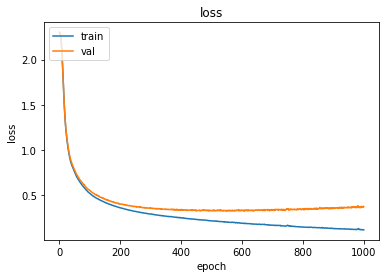

In [19]:
plt.plot(np.arange(1000), tr_loss)
plt.plot(np.arange(1000), te_loss)
plt.title("loss")
plt.xlabel('epoch')
plt.ylabel("loss")
plt.legend(['train', 'val'], loc='upper left')

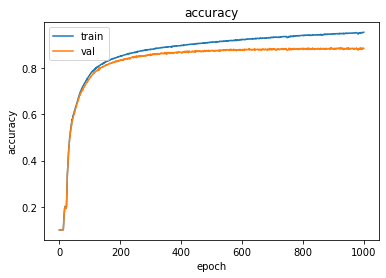

In [20]:
plt.plot(np.arange(1000), tr_accuracy)
plt.plot(np.arange(1000), te_accuracy)
plt.title("accuracy")
plt.xlabel('epoch')
plt.ylabel("accuracy")
plt.legend(['train', 'val'], loc='upper left')

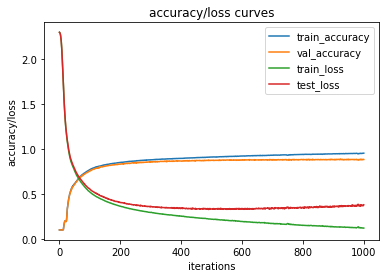

In [21]:
plt.plot(np.arange(1000), tr_accuracy)
plt.plot(np.arange(1000), te_accuracy)
plt.plot(np.arange(1000), tr_loss)
plt.plot(np.arange(1000), te_loss)
plt.title("accuracy/loss curves")
plt.xlabel('iterations')
plt.ylabel("accuracy/loss")
plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'test_loss'], loc='upper right')